<a name="table_of_contents"></a>
# Content: 
1) [Of cats and cookies](#stage_1)

- [Loading libraries and dataset.](#s_1)
- [Data preprocessing](#s_2)

2) [Getting Started with EDA](#stage_2)

3) [Retentions](#stage_3)

4) [Should we be confident in the difference?](#stage_4)

5) [Zooming in on the difference](#stage_5)

6) [The probability of a difference](#stage_6)

7) [The conclusion](#stage_7)

<a name="stage_1"></a>
## Of cats and cookies
[To the table of contents](#table_of_contents)
<p><a href="https://www.facebook.com/cookiecatsgame">Cookie Cats</a> is a hugely popular mobile puzzle game developed by <a href="http://tactile.dk">Tactile Entertainment</a>. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats. We're not kidding! Check out this short demo:</p>
<p><a href="https://youtu.be/GaP5f0jVTWE"><img src="https://assets.datacamp.com/production/project_184/img/cookie_cats_video.jpeg" style="width: 500px"></a></p>
<p>As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.</p>
<p><img src="https://assets.datacamp.com/production/project_184/img/cc_gates.png" alt></p>
<p>But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention. But before we get to that, a key step before undertaking any analysis is understanding the data. So let's load it in and take a look!</p>

<a name="s_1"></a>
### Loading libraries and dataset.
[To the table of contents](#table_of_contents)

In [1]:
! pip install missingno


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import math
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
df= pd.read_csv("cookieсats.csv")
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


<a name="s_2"></a>
### Data preprocessing:
[To the table of contents](#table_of_contents)

<p>The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. As a sanity check, let's see if there are roughly the same number of players in each AB group. </p>

Let's  carry out a primary analysis of the data: checking for duplicates and missing values:

In [3]:
print(df.shape)
print('\n----------------------------')
df.info()

(90189, 5)

----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


<AxesSubplot:>

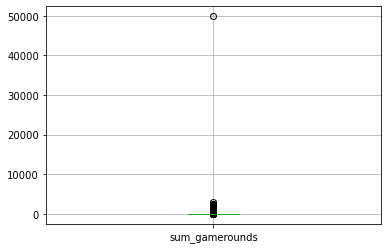

In [5]:
df.boxplot(column='sum_gamerounds')

#### My notice:
There is a strong outlier that spoils the data distribution. Perhaps this is a developer account that "passed" the game to the end, or it's a bot or a cheater. I'll remove this outlier.

In [6]:
df=df[df['sum_gamerounds']!=49854]

In [7]:
print('Duplicates in the dataset :', df.duplicated().sum())
print('\nMissing values in the dataset:', df.isna().sum())

Duplicates in the dataset : 0

Missing values in the dataset: userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


In [8]:
df=df.rename(columns={'userid':'user_id'})
df.head(2)

,user_id,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False


##### Result:
The data is clean, no additional action was required

#### My notices
I would like to have more data (for example, data by date, user actions and methods of passing the first level) and without the initial grouping by gate_30 and gate_40.

<a name="stage_2"></a>
## Getting Started with EDA
[To the table of contents](#table_of_contents)
<p><img src="https://assets.datacamp.com/production/project_184/img/belle_cookie.png" style="width:200px; float:right"> </p>
<p>It looks like there is roughly the same number of players in each group, nice!</p>
<p>The focus of this analysis will be on how the gate placement affects player retention, but just for fun: Let's plot the distribution of the number of game rounds players played during their first week playing the game.</p>

In [9]:
data_per_group=df.groupby('version')['sum_gamerounds'].agg(['count','mean','median','std','max'])
data_per_group

,count,mean,median,std,max
version,,,,,
gate_30,44699,51.342111,17,102.057598,2961
gate_40,45489,51.298776,16,103.294416,2640


In [10]:
print('Unique players:', df['user_id'].nunique())
print('\nUnique players in group A (gate_30):', df[df['version']=='gate_30']['user_id'].nunique())
print('\nUnique players in group B (gate_40):', df[df['version']=='gate_40']['user_id'].nunique())


Unique players: 90188

Unique players in group A (gate_30): 44699

Unique players in group B (gate_40): 45489


In [11]:
game_rounds = df.groupby('sum_gamerounds')['user_id'].count().reset_index()
game_rounds.head()

,sum_gamerounds,user_id
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629


<AxesSubplot:>

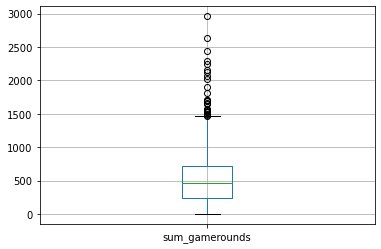

In [12]:
game_rounds.boxplot(column='sum_gamerounds')

##### Let's build diagrams:

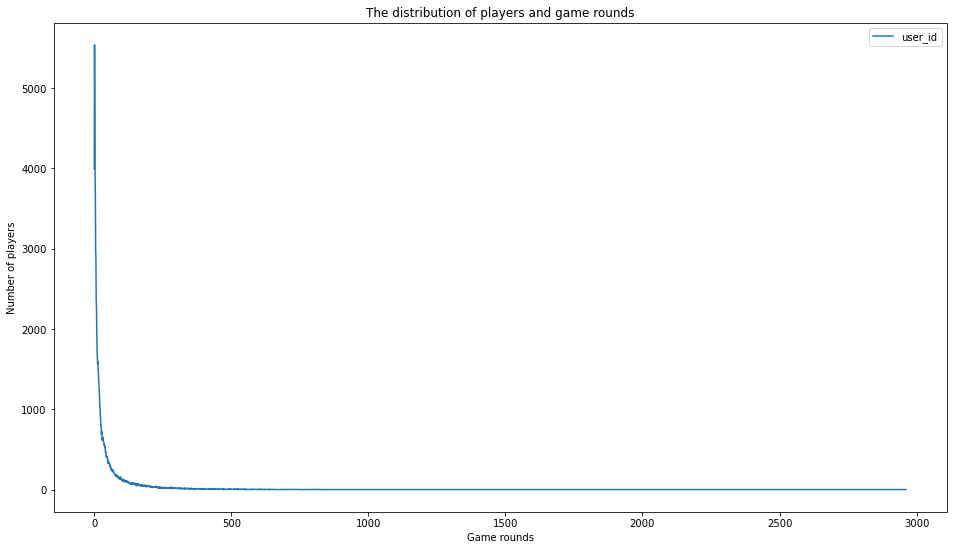

In [13]:
ax = game_rounds.plot('sum_gamerounds',figsize=(16, 9))
plt.title('The distribution of players and game rounds') 
ax.set_xlabel('Game rounds')
ax.set_ylabel('Number of players')
plt.show()

##### My notice:
Too much data with high values, so "divine" people do not play, you need to take 100 game rounds, as often occurs.

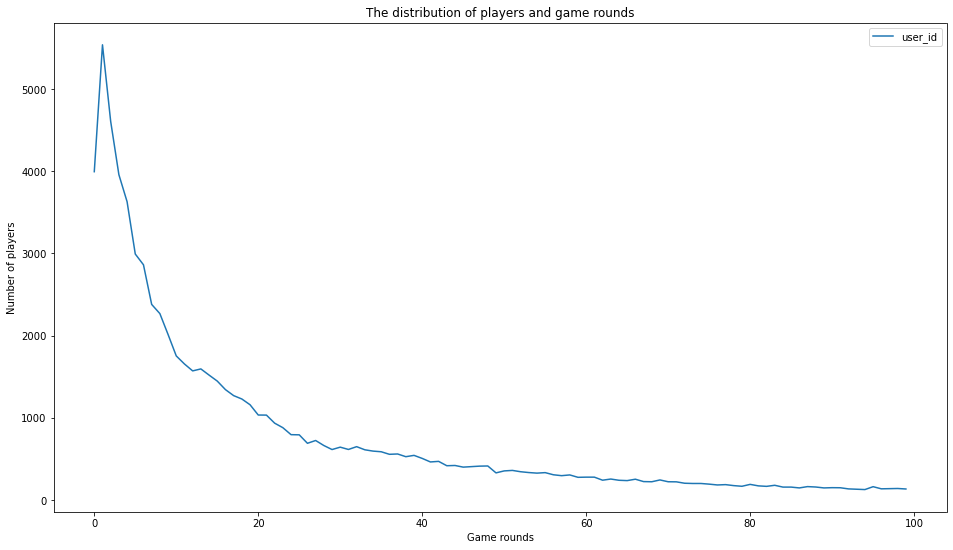

In [14]:
ax = game_rounds.head(100).plot('sum_gamerounds',figsize=(16, 9))
plt.title('The distribution of players and game rounds') 
ax.set_xlabel('Game rounds')
ax.set_ylabel('Number of players')
plt.show()

##### And what kind of schedules will be in different A/B groups?

In [15]:
cummulative_group_A = df.query('version=="gate_30"')
cummulative_group_B = df.query('version=="gate_40"')
cummulative_group_A.head(10)

,user_id,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
6,1066,gate_30,0,False,False
11,2101,gate_30,0,False,False
13,2179,gate_30,39,True,False
14,2218,gate_30,305,True,True
15,2382,gate_30,73,True,False
16,2392,gate_30,14,True,False
17,2451,gate_30,204,True,True
18,2482,gate_30,108,True,True


In [16]:
cummulative_group_B.head(10)

,user_id,version,sum_gamerounds,retention_1,retention_7
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False
10,1842,gate_40,3,False,True
12,2132,gate_40,30,True,False
19,2502,gate_40,1,False,False


In [17]:
game_rounds_A = cummulative_group_A.groupby('sum_gamerounds')['user_id'].count().reset_index()
game_rounds_A.head()

,sum_gamerounds,user_id
0,0,1937
1,1,2749
2,2,2198
3,3,1899
4,4,1831


In [18]:
game_rounds_B = cummulative_group_B.groupby('sum_gamerounds')['user_id'].count().reset_index()
game_rounds_B.head()

,sum_gamerounds,user_id
0,0,2057
1,1,2789
2,2,2408
3,3,2059
4,4,1798


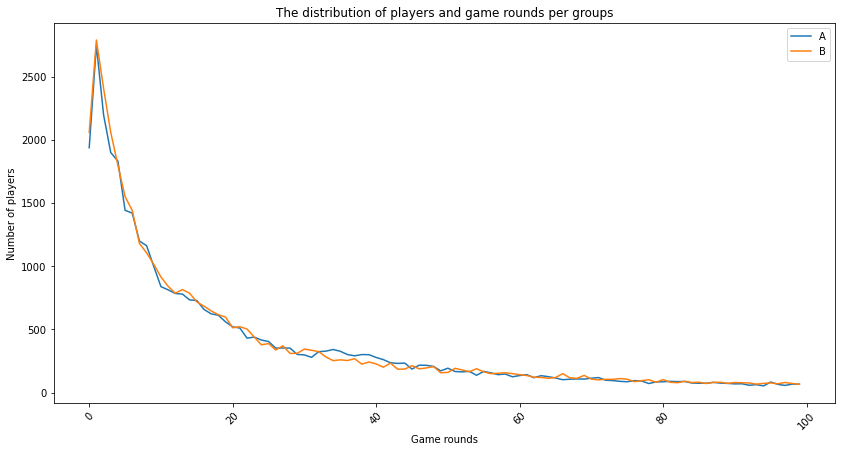

In [19]:
plt.figure(figsize=(14, 7))
plt.plot(game_rounds_A['user_id'].head(100), label='A')
plt.plot(game_rounds_B['user_id'].head(100), label='B')
plt.title('The distribution of players and game rounds per groups')
plt.ylabel('Number of players')
plt.xlabel('Game rounds')
plt.xticks(rotation=45)
plt.legend()
plt.show() 

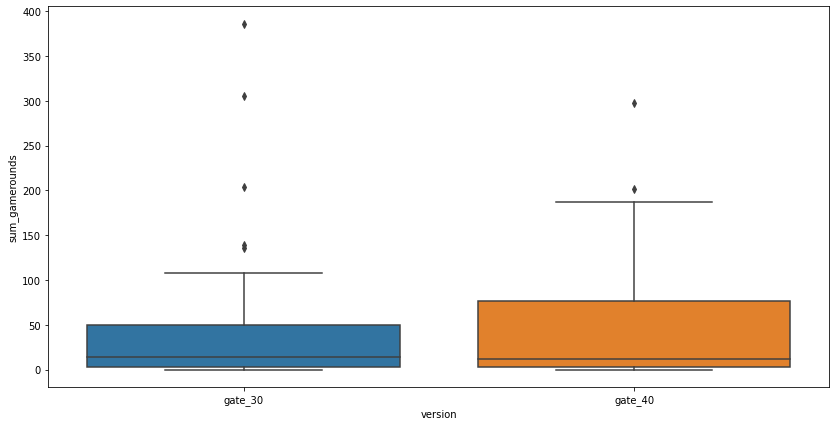

In [20]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.boxplot(data=df.head(100),x='version',y='sum_gamerounds')
plt.show()

##### Results:
The first group has more outliers, but the second group showed the best results in passing levels.

<a name="stage_3"></a>
## Retentions
[To the table of contents](#table_of_contents)

In the plot above we can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked!

What we want is for players to like the game and to get hooked. A common metric in the video gaming industry for how fun and engaging a game is 1-day retention: The percentage of players that comes back and plays the game one day after they have installed it. The higher 1-day retention is, the easier it is to retain players and build a large player base.

As a first step, let's look at what 1-day retention is overall, and just look at a 7-day retention.

In [21]:
print('The overall retention for 1 day is: {} %'.format(np.round(len(df[df['retention_1'] == True]) / len(df['retention_1']) * 100, 2)))
print('\nThe overall retention for 7 day is: {} %'.format(np.round(len(df[df['retention_7'] == True]) / len(df['retention_7']) * 100, 2)))
print('\nThe overall mean retention for 1 day is: {}'.format(np.round(df['retention_1'].mean(),4)))
print('\nThe overall mean retention for 7 day is: {}'.format(np.round(df['retention_7'].mean(),4)))
print('\n----------------------------------------------------------------------------------------------------------------------------')
print('\nThe group A (variation 30) retention for 1 day is: {} %'.format(np.round(len(cummulative_group_A[cummulative_group_A['retention_1'] == True]) / len(cummulative_group_A['retention_1']) * 100, 2)))
print('\nThe group A (variation 30) retention for 7 day is: {} %'.format(np.round(len(cummulative_group_A[cummulative_group_A['retention_7'] == True]) / len(cummulative_group_A['retention_7']) * 100, 2)))
print('\nThe group A mean retention for 1 day is: {}'.format(np.round(cummulative_group_A['retention_1'].mean(),4)))
print('\nThe group A mean retention for 7 day is: {}'.format(np.round(cummulative_group_A['retention_7'].mean(),4)))
print('\n------------------------------------------------------------------------------------------------------------------------------')
print('\nThe group B (variation 40) retention for 1 day is: {} %'.format(np.round(len(cummulative_group_B[cummulative_group_B['retention_1'] == True]) / len(cummulative_group_B['retention_1']) * 100, 2)))
print('\nThe group B (variation 40) retention for 7 day is: {} %'.format(np.round(len(cummulative_group_B[cummulative_group_B['retention_7'] == True]) / len(cummulative_group_B['retention_7']) * 100, 2)))
print('\nThe group B mean retention for 1 day is: {}'.format(np.round(cummulative_group_B['retention_1'].mean(),4)))
print('\nThe group B mean retention for 7 day is: {}'.format(np.round(cummulative_group_B['retention_7'].mean(),4)))

The overall retention for 1 day is: 44.52 %

The overall retention for 7 day is: 18.61 %

The overall mean retention for 1 day is: 0.4452

The overall mean retention for 7 day is: 0.1861

----------------------------------------------------------------------------------------------------------------------------

The group A (variation 30) retention for 1 day is: 44.82 %

The group A (variation 30) retention for 7 day is: 19.02 %

The group A mean retention for 1 day is: 0.4482

The group A mean retention for 7 day is: 0.1902

------------------------------------------------------------------------------------------------------------------------------

The group B (variation 40) retention for 1 day is: 44.23 %

The group B (variation 40) retention for 7 day is: 18.2 %

The group B mean retention for 1 day is: 0.4423

The group B mean retention for 7 day is: 0.182


The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30.

But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.

<a name="stage_4"></a>
## Should we be confident in the difference?
[To the table of contents](#table_of_contents)
<p>It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?</p>
<p>There are a couple of ways we can get at the certainty of these retention numbers. Here we will use bootstrapping: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.</p>

Like with 1-day retention, we see that 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. We also see that the overall 7-day retention is lower than the overall 1-day retention; fewer people play a game a week after installing than a day after installing.

But as before, let's use bootstrap analysis to figure out how certain we should be of the difference between the AB-groups.

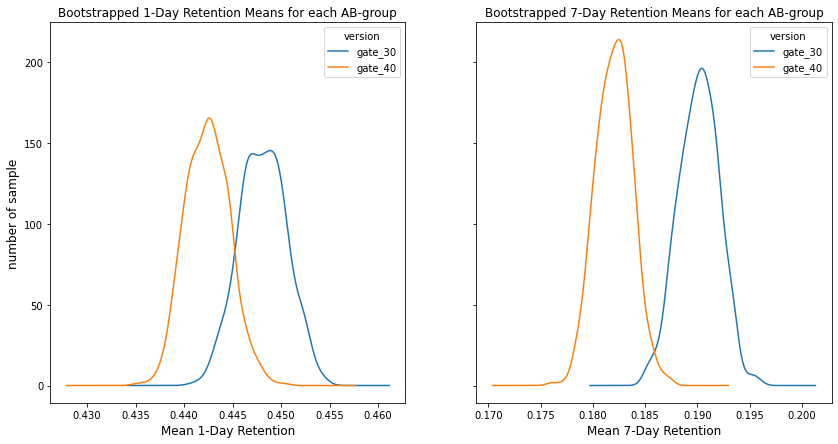

In [22]:
# Creating a list with bootstrapped means for each AB-group
boot_1d = []
boot_7d = []
iterations=500
for i in range(iterations):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,7))

boot_1d.plot.kde(ax=ax1)
ax1.set_title('Bootstrapped 1-Day Retention Means for each AB-group')
ax1.set_xlabel('Mean 1-Day Retention',size=12)
ax1.set_ylabel("number of sample",size=12)

boot_7d.plot.kde(ax=ax2)
ax2.set_title('Bootstrapped 7-Day Retention Means for each AB-group')
ax2.set_xlabel('Mean 7-Day Retention',size=12)

             
plt.show()

##### What happens if you increase the number of iterations to 1000?

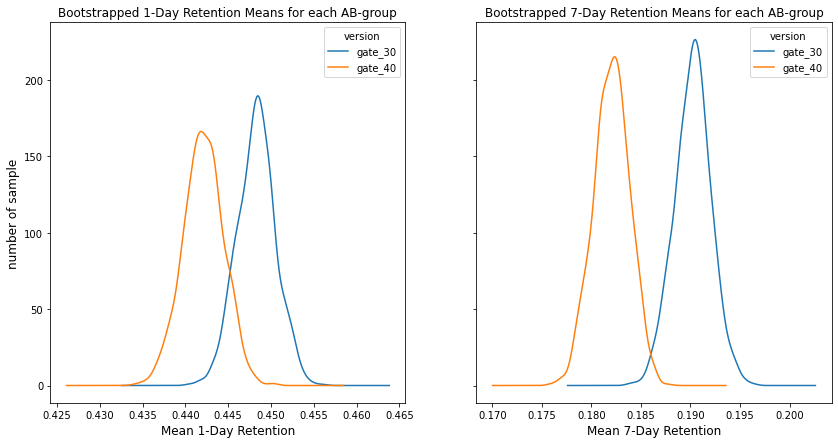

In [23]:
# Creating a list with bootstrapped means for each AB-group
boot_1d = []
boot_7d = []
iterations=1000
for i in range(iterations):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,7))

boot_1d.plot.kde(ax=ax1)
ax1.set_title('Bootstrapped 1-Day Retention Means for each AB-group')
ax1.set_xlabel('Mean 1-Day Retention',size=12)
ax1.set_ylabel("number of sample",size=12)

boot_7d.plot.kde(ax=ax2)
ax2.set_title('Bootstrapped 7-Day Retention Means for each AB-group')
ax2.set_xlabel('Mean 7-Day Retention',size=12)

plt.show()

<a name="stage_5"></a>
## Zooming in on the difference
[To the table of contents](#table_of_contents)
<p>These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference, albeit small. Let's zoom in on the difference in 1-day retention</p>
<p>(<em>Note that in this notebook we have limited the number of bootstrap replication to 500 to keep the calculations quick. In "production" we would likely increase this to a much larger number, say, 10 000.</em>)</p>

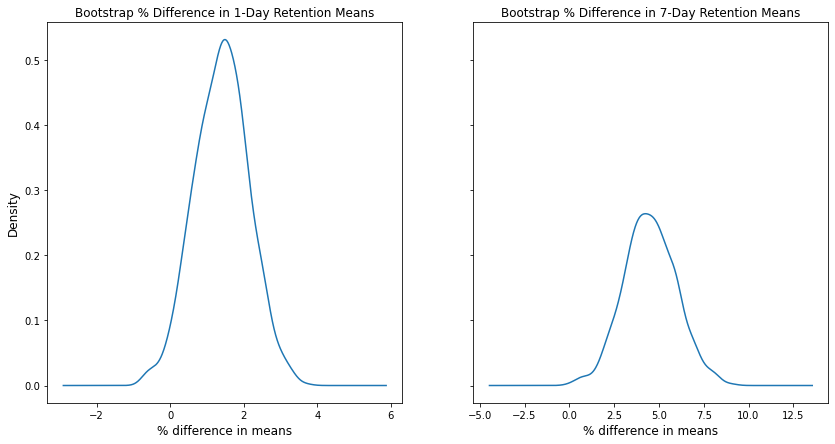

In [24]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d['gate_30']-boot_1d['gate_40'])/boot_1d['gate_40'] * 100
boot_7d['diff'] = (boot_7d['gate_30']-boot_7d['gate_40'])/boot_7d['gate_40'] * 100

# Ploting the bootstrap % difference
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,7))
boot_1d['diff'].plot.kde(ax=ax1)
ax1.set_title('Bootstrap % Difference in 1-Day Retention Means')
ax1.set_xlabel("% difference in means",size=12)
ax1.set_ylabel("Density",size=12)

boot_7d['diff'].plot.kde(ax=ax2)
ax2.set_title('Bootstrap % Difference in 7-Day Retention Means')
ax2.set_xlabel("% difference in means",size=12)

plt.show()

##### Let's overlay two graphs on top of one for better perception.

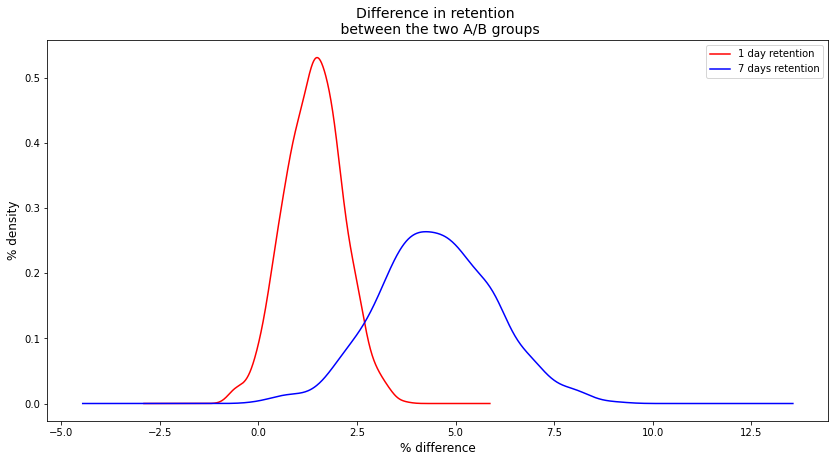

In [25]:
fig, (ax1) = plt.subplots(1, 1,figsize=(14,7))
boot_1d['diff'].plot.kde(ax=ax1, c="red", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "blue", label = "7 days retention")
ax1.set_xlabel("% difference",size=12)
ax1.set_ylabel("% density",size=12)
ax1.set_title("Difference in retention \n between the two A/B groups", size=14)
plt.legend()
plt.show()

<a name="stage_6"></a>
## The probability of a difference
[To the table of contents](#table_of_contents)
<p><img src="https://assets.datacamp.com/production/project_184/img/ziggy_smiling.png" style="width:200px; float:left"> </p>
<p>From this chart, we can see that the most likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. But what is the <em>probability</em> that the difference is above 0%? Let's calculate that as well.</p>

In [26]:
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

print('Calculating the probability that 1-day retention is greater when the gate is at level 30: {0:.1%}'.format(prob_1))
print('\nCalculating the probability that 7-day retention is greater when the gate is at level 30: {0:.1%}'.format(prob_7))

Calculating the probability that 1-day retention is greater when the gate is at level 30: 97.2%

Calculating the probability that 7-day retention is greater when the gate is at level 30: 100.0%


In [27]:
move_to_level_40 = False
print('The desision of moving to level 40 is:', move_to_level_40)

The desision of moving to level 40 is: False


<a name="stage_7"></a>
## The conclusion
[To the table of contents](#table_of_contents)
<p>The bootstrap result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should <strong>not</strong> move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention <em>is</em> one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.</p>
<p><img src="https://assets.datacamp.com/production/project_184/img/mr_waffles_smiling.png" style="width:200px; float:left"> </p>
<p>So, why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of <em>hedonic adaptation</em> can give one explanation for this. In short, hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously. By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it. </p>